모듈 ∙ 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.optimizers.legacy import Adam

데이터 불러오기 ∙ 전처리

In [2]:
def filter_df(df): #데이터프레임 필터링
    # 첫 번째 열에서 같은 값을 가진 행의 수를 계산합니다.
    row_counts = df['0'].value_counts()

    # 가장 많은 행의 수를 찾습니다.
    max_row_count = row_counts.max()

    # 가장 많은 행의 수에 해당하는 행만 분류합니다.
    filtered = pd.DataFrame(df[df['0'].isin(row_counts[row_counts == max_row_count].index)])

    return filtered

# 데이터 로드   
stock_df = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData.csv',low_memory=False)
pred_df = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData_Pred.csv',low_memory=False)

#데이터 필터링
filter_stock = filter_df(stock_df)
filter_label = filter_stock['18']

filter_pred= filter_df(pred_df)

# 예측에 필요한 데이터 
pred_ticker = filter_pred['0']#종목코드 저장

# 불필요한 데이터 삭제
filter_stock = filter_stock.drop({'0','1','7','18'},axis=1) #날자, 상승율, 5%이상 상승여부 삭제 
filter_pred = filter_pred.drop({'0','1','7'},axis=1)#날자, 상승율 삭제


데이터 전처리

In [3]:
scaler = MinMaxScaler()
stock_label = scaler.fit_transform(filter_label.values.reshape(-1, 1))

데이터 분할

In [4]:
# 훈련 및 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(filter_stock, stock_label, test_size=0.2, random_state=42)

GRU 모델 정의

In [5]:
# GRU 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(32, input_shape=(X_train.shape[1],1),return_sequences=True))
model.add(tf.keras.layers.GRU(64,return_sequences=False))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 조기 종료 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 28, 64)            12864     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 37889 (148.00 KB)
Trainable params: 37889 (148.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


모델 훈련

In [6]:
# 모델 훈련
model.fit(X_train,y_train,epochs=25, validation_data=(X_test,y_test),callbacks=[early_stopping])

# 모델 저장
model.save("GRU_Model.h5")

Epoch 1/25
24726/24726 [==============================] - 306s 12ms/step - loss: 0.1189 - accuracy: 0.9620 - val_loss: 0.1036 - val_accuracy: 0.9646
Epoch 2/25
24726/24726 [==============================] - 302s 12ms/step - loss: 0.1094 - accuracy: 0.9640 - val_loss: 0.1069 - val_accuracy: 0.9645
Epoch 3/25
24726/24726 [==============================] - 303s 12ms/step - loss: 0.1080 - accuracy: 0.9642 - val_loss: 0.1052 - val_accuracy: 0.9648
Epoch 4/25
24726/24726 [==============================] - 304s 12ms/step - loss: 0.1088 - accuracy: 0.9642 - val_loss: 0.1076 - val_accuracy: 0.9646
Epoch 5/25
24726/24726 [==============================] - 304s 12ms/step - loss: 0.1078 - accuracy: 0.9644 - val_loss: 0.1051 - val_accuracy: 0.9651
Epoch 6/25
24726/24726 [==============================] - 304s 12ms/step - loss: 0.1069 - accuracy: 0.9645 - val_loss: 0.1034 - val_accuracy: 0.9652
Epoch 7/25
24726/24726 [==============================] - 298s 12ms/step - loss: 0.1059 - accuracy: 0.9645

/Users/moon/anaconda3/envs/ML/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


모델 평가

In [7]:
# 모델 로드
loaded_model = tf.keras.models.load_model("GRU_Model.h5")

# 모델을 사용하여 주가 상승 여부 예측
test = loaded_model.predict(X_test)

6182/6182 [==============================] - 17s 3ms/step


In [8]:
# 예측 결과를 이진값(0 또는 1)으로 변환
binary_predictions = (test > 0.5).astype(int)

# 예측 결과 출력
correct_predictions = np.equal(binary_predictions, y_test)  # 정확하게 예측한 경우 True, 그렇지 않으면 False
accuracy = np.mean(correct_predictions)  # 정확도 계산

print(f"정확도: {accuracy * 100:.2f}%")

정확도: 96.54%


예측

In [9]:
def make_six_digit_list(input_list):
    six_digit_list = []

    for item in input_list:
        # 현재 항목의 길이를 확인
        item_str = str(item)
        item_len = len(item_str)

        if item_len < 6:
            # 6자리가 안되는 항목은 앞에 0을 채워서 6자리로 만듭니다.
            zero_padding = '0' * (6 - item_len)
            six_digit_item = zero_padding + item_str
            six_digit_list.append(six_digit_item)
        else:
            # 이미 6자리인 경우 그대로 유지
            six_digit_list.append(item_str)

    return six_digit_list

In [10]:
T_pred = loaded_model.predict(filter_pred)

231/231 [==============================] - 1s 3ms/step


In [11]:
# 5% 이상 오를 종목 식별
rising_stocks = [ticker for i, ticker in enumerate(pred_ticker) if T_pred[i] > 0.9]
rising_stocks = list(map(str, rising_stocks))
result = list(set(rising_stocks))
result = make_six_digit_list(result)
print("내일 5% 이상 상승할 종목:", result)
print(len(result))

내일 5% 이상 상승할 종목: ['002360', '053050', '082850', '005870', '010820', '129920', '014915', '218150', '039490', '016880', '117580', '094940', '014530', '004090', '013810', '204610', '238120', '065450', '152550', '024060', '234100', '189690', '000440']
23


예측한 결과 검증

            Open  High  Low  Close    Volume    Change
Date                                                  
2023-10-13   715   843  694    762  28222737  0.073239
            Open  High   Low  Close    Volume    Change
Date                                                   
2023-10-13  4135  4870  3885   4345  46088520  0.091709
            Open  High   Low  Close   Volume    Change
Date                                                  
2023-10-13  2470  2530  2365   2385  2685315 -0.042169
            Open  High   Low  Close   Volume   Change
Date                                                 
2023-10-13  5540  6020  5380   5720  2020920  0.02509
            Open  High   Low  Close   Volume    Change
Date                                                  
2023-10-13  3645  3805  3520   3605  6095436 -0.005517
            Open   High   Low  Close   Volume    Change
Date                                                   
2023-10-13  9690  10550  9370  10090  9186878  0.036999
       

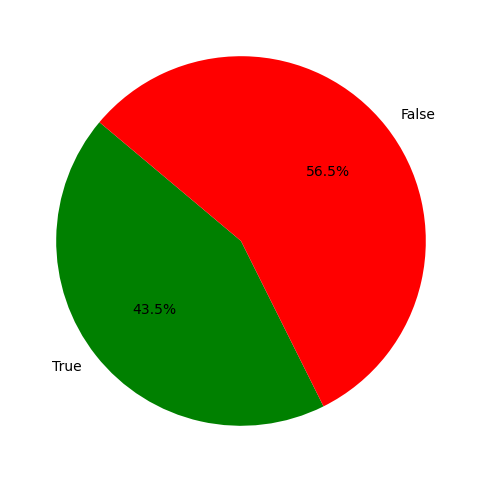

In [12]:
def check_price_increase(stock_codes):
    result = {}
    
    for code in stock_codes:
        df = fdr.DataReader(code,'2023-10-12','2023-10-13')
        print(df.tail(1))
        
        if len(df) < 2:
            result[code] = False
        else:
            today_close = df['Change'].iloc[-1]

            if today_close >=  0.05 :
                result[code] = True
            else:
                result[code] = False
    return result

result_TF = check_price_increase(result)
result_TF = list(result_TF.values())

# True와 False의 개수를 세어 비율을 계산
true_count = sum(result_TF)
false_count = len(result_TF) - true_count

# 비율을 파이그래프로 표현
labels = ['True', 'False']
sizes = [true_count, false_count]
colors = ['green', 'red']

# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# 그래프 표시
plt.show() 